This file looks at producing example images

Let's try to sharpen the images or look at the surrounding area of each pixel to highlight areas that may have an issue. Then let's look at
trying to quantify the noise in each image.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from copy import copy
from matplotlib import cm, colors

objectwidth = 83
objectheight = 122
xspacing = 133
yspacing = 270
xstart = 293
ystart = 268
xend = 1730
yend = 1770
powderthickness = 80
endlayer = 187

paths = pathlib.Path('./OT data 80 um/int').glob('*.tif')
paths_sorted = [x for x in paths]
paths_sorted.sort()
integrals = np.array([np.array(plt.imread(path)) for path in paths_sorted])[0:endlayer]

objectinfo = pd.read_csv('Parameters.csv', names=["Object", "P", "S", "H", "Porosity", "Label"])
objectinfo.insert(1, "VED", objectinfo.P * 1000/(objectinfo.S * objectinfo.H * powderthickness))
objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
    ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])
objectinfo = coorddf.join(objectinfo)

del coorddf
del objectCoordinates
del paths_sorted

Text(0.5, 1.0, 'Relative temperature for each of the objects')

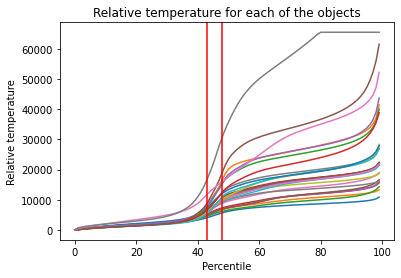

In [3]:
xs = np.arange(0, 100)
for index, object in objectinfo.sort_values(by=['VED']).iterrows():
    plt.plot(xs, np.percentile(integrals[:,object.ystart:object.yend, object.xstart:object.xend], xs))
plt.axvline(x=43, color='r', linestyle='-')
plt.axvline(x=48, color='r', linestyle='-')
plt.xlabel("Percentile")
plt.ylabel("Relative temperature")
plt.title("Relative temperature for each of the objects")

Lets sharpen the image and then filter out all background pixels and set them to nan

/var/folders/d9/k1mwdb1x1sb5ly3k528g3qcr0000gn/T/ipykernel_54739/3665984783.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


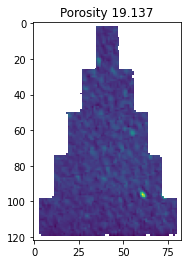

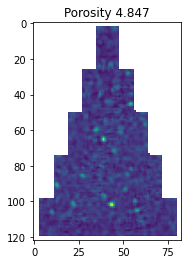

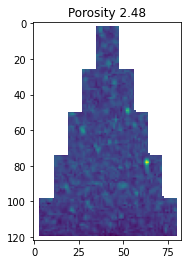

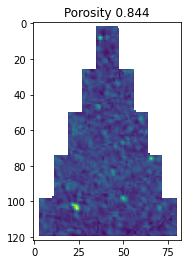

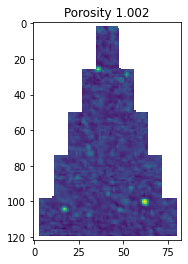

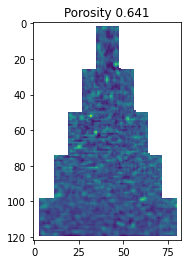

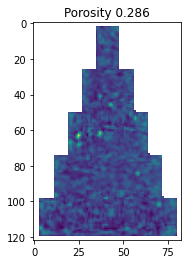

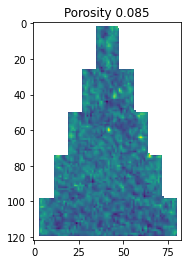

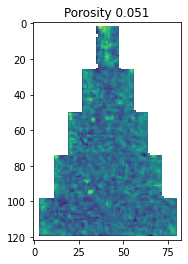

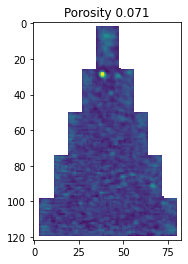

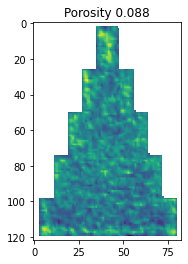

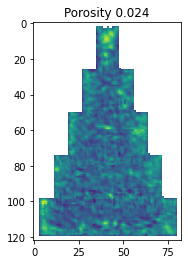

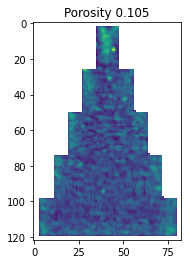

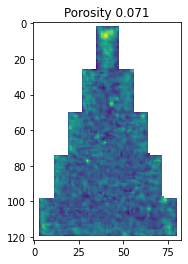

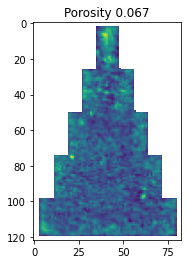

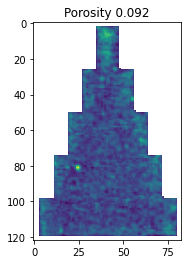

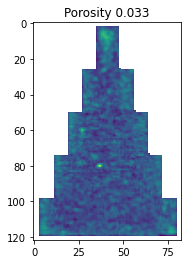

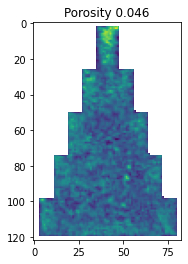

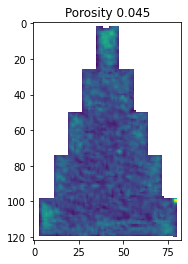

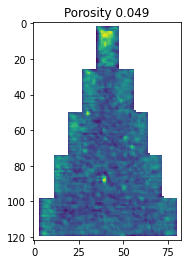

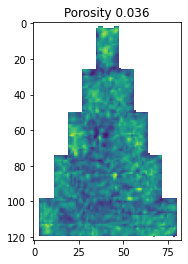

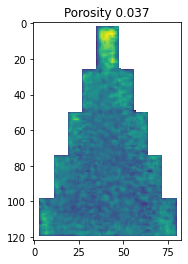

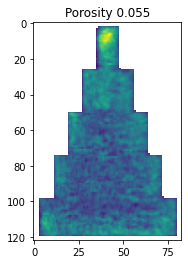

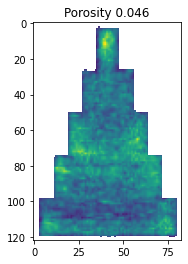

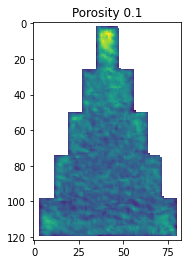

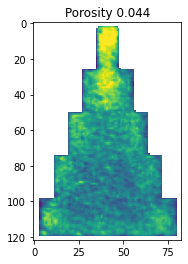

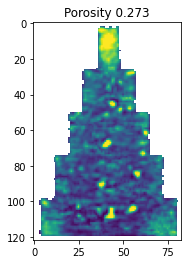

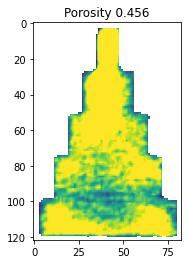

<Figure size 432x288 with 0 Axes>

In [4]:
import cv2
# Sharpening
sharpeningKernel = np.array([   [ -1, -1,  -1],
                                [-1,  9, -1],
                                [ -1, -1,  -1]
                            ])
sharpened = np.array([cv2.filter2D(src=image, ddepth=-1, kernel=sharpeningKernel) for image in integrals])
# End of sharpening
# Start of filtering
# A better approach to filtering would be some sort of clustering or image segmentation
emptyRatio = 47
filtered = np.full(np.shape(integrals), np.nan)
raw = np.full(np.shape(integrals), np.nan)
for index, object in objectinfo.sort_values(by=['VED']).iterrows():
    xs = sharpened[:, object.ystart:object.yend, object.xstart:object.xend]
    rawxs = np.array(sharpened[:, object.ystart:object.yend, object.xstart:object.xend], copy=True, dtype=np.float32)
    sum = np.sum(xs, axis=0)
    limit = np.percentile(sum, emptyRatio)
    filter = sum >= limit
    (endLayer, _, _) = sharpened.shape
    filter = np.repeat([filter], endLayer, 0)
    avg = np.mean(xs, where=filter)
    stddev = np.std(xs, where=filter)
    xs = (xs - avg) / avg
    xs[~filter] = np.nan
    rawxs[~filter] = np.nan
    plt.imshow(xs[93])
    plt.title("Porosity " + str(object.Porosity))
    plt.figure()
    filtered[:, object.ystart:object.yend, object.xstart:object.xend] = xs
    raw[:, object.ystart:object.yend, object.xstart:object.xend] = rawxs


Now, let's calculate the neighbourhood matrix

In [8]:

windowSize = 7
# This could also be a gaussian
kernel = np.array([[1, 1, 1],
                   [1, 1, 1],
                   [1, 1, 1]])/9
_, object = next(objectinfo.sort_values(by=['VED']).iterrows())

sharpened[:, object.ystart:object.yend, object.xstart:object.xend]

# Gaussian below
veryBlurredLayers = np.array([cv2.GaussianBlur(image, (3,3), 0) for image in raw])
(endLayer, _, _) = veryBlurredLayers.shape
print(endLayer)
neighbourhoodValues = np.array([np.sum(veryBlurredLayers[layerIndex-windowSize:layerIndex], axis=0)/windowSize
                               for layerIndex in range(windowSize, endLayer)])
# plt.imshow(neighbourhoodValues[93, object.ystart:object.yend, object.xstart:object.xend])
# plt.title("Gaussian blur")
# plt.figure()

# Grid below
veryBlurredLayers = np.array([cv2.filter2D(src=image, ddepth=-1, kernel=kernel) for image in raw])
(endLayer, _, _) = veryBlurredLayers.shape
print(endLayer)
rawNeighbourhoodValues = np.array([np.sum(veryBlurredLayers[layerIndex-windowSize:layerIndex], axis=0)/windowSize
                               for layerIndex in range(windowSize, endLayer)])
# plt.imshow(neighbourhoodValues[93, object.ystart:object.yend, object.xstart:object.xend])
# plt.title("Boxblur")
# plt.figure()

del veryBlurredLayers

187
187


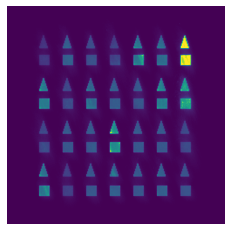

In [6]:
plt.imshow(integrals[92])
plt.axis('off')
plt.savefig("powderbed.png", dpi=300)

H2


<Figure size 432x288 with 0 Axes>

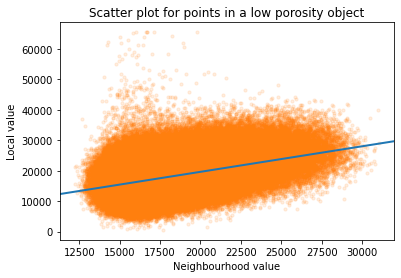

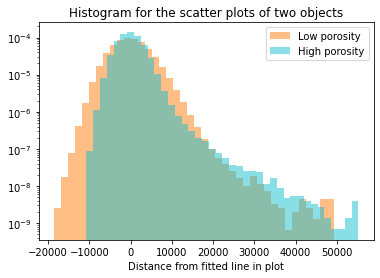

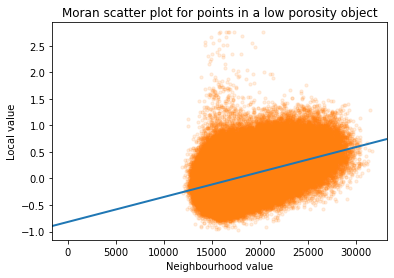

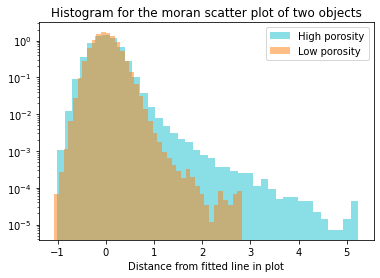

<Figure size 432x288 with 0 Axes>

In [10]:
object = objectinfo.iloc[2]

xs = filtered[windowSize:, object.ystart:object.yend, object.xstart:object.xend]
ys = neighbourhoodValues[:, object.ystart:object.yend, object.xstart:object.xend]
filter = np.logical_and(np.isfinite(xs), np.isfinite(ys))
line = np.polyfit(ys[filter].flatten(), xs[filter].flatten(), 1)
p = np.poly1d(line)

rawxs = raw[windowSize:, object.ystart:object.yend, object.xstart:object.xend]
rawys = rawNeighbourhoodValues[:, object.ystart:object.yend, object.xstart:object.xend]
rawfilter = np.logical_and(np.isfinite(rawxs), np.isfinite(rawys))
rawline = np.polyfit(rawys[rawfilter].flatten(), rawxs[rawfilter].flatten(), 1)
rawp = np.poly1d(rawline)

object = objectinfo.iloc[1]

xs2 = filtered[windowSize:, object.ystart:object.yend, object.xstart:object.xend]
ys2 = neighbourhoodValues[:, object.ystart:object.yend, object.xstart:object.xend]
filter2 = np.logical_and(np.isfinite(xs2), np.isfinite(ys2))
line2 = np.polyfit(ys2[filter2].flatten(), xs2[filter2].flatten(), 1)
p2 = np.poly1d(line2)

rawxs2 = raw[windowSize:, object.ystart:object.yend, object.xstart:object.xend]
rawys2 = rawNeighbourhoodValues[:, object.ystart:object.yend, object.xstart:object.xend]
rawfilter2 = np.logical_and(np.isfinite(rawxs2), np.isfinite(rawys2))
rawline2 = np.polyfit(rawys2[rawfilter2].flatten(), rawxs2[rawfilter2].flatten(), 1)
rawp2 = np.poly1d(rawline2)

print(object.Object)

plt.scatter(rawys[rawfilter].flatten(), rawxs[rawfilter].flatten(), color='tab:orange', s=10, alpha=0.125)
# plt.scatter(rawys2[rawfilter2].flatten(), rawxs2[rawfilter2].flatten(), color='tab:red', s=10, alpha=0.125)
plt.axline((20000, rawp(20000)), (20001, rawp(20001)), linewidth=2, color='tab:blue')
plt.title("Scatter plot for points in a low porosity object")
plt.xlabel("Neighbourhood value")
plt.ylabel("Local value")
plt.savefig('figures/scatter-example.png', dpi=300, bbox_inches='tight')
plt.figure()

plt.hist((rawxs-rawp(rawys)).flatten(), bins=40, alpha=0.5, density=True, color='tab:orange',  label="Low porosity",)
plt.hist((rawxs2-rawp2(rawys2)).flatten(), bins=40, alpha=0.5, density=True, color='tab:cyan',  label="High porosity",)
plt.legend()
plt.title("Histogram for the scatter plots of two objects")
plt.xlabel("Distance from fitted line in plot")
plt.yscale('log')
plt.savefig('figures/histogram-scatter.png', dpi=300, bbox_inches='tight')
plt.figure()



plt.scatter(ys[filter].flatten(), xs[filter].flatten(), color='tab:orange', s=10, alpha=0.125)
# plt.scatter(ys2[filter2].flatten(), xs2[filter2].flatten(), color='tab:red', s=10, alpha=0.125)
plt.axline((-0.1, p(-0.1)), (0, p(0)), linewidth=2, color='tab:blue')
plt.title("Moran scatter plot for points in a low porosity object")
plt.xlabel("Neighbourhood value")
plt.ylabel("Local value")
plt.savefig('figures/moran-example.png', dpi=300, bbox_inches='tight')
plt.figure()

# plt.hist((xs-p(ys)).flatten(), bins=40, alpha=0.5, density=True, color='tab:orange',  label="Low porosity",)
plt.hist((xs2-p2(ys2)).flatten(), bins=40, alpha=0.5, density=True, color='tab:cyan',  label="High porosity",)
plt.hist((xs-p(ys)).flatten(), bins=40, alpha=0.5, density=True, color='tab:orange',  label="Low porosity",)
plt.legend()
plt.title("Histogram for the moran scatter plot of two objects")
plt.xlabel("Distance from fitted line in plot")
plt.yscale('log')
plt.savefig('figures/histogram-moran.png', dpi=300, bbox_inches='tight')
plt.figure()
    

<Figure size 432x288 with 0 Axes>

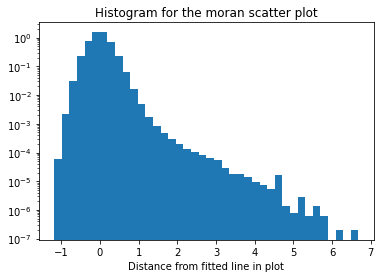

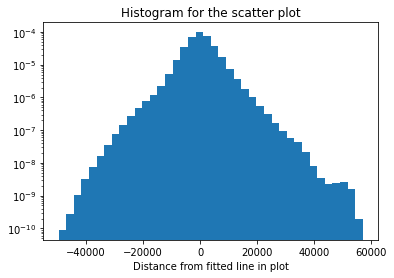

<Figure size 432x288 with 0 Axes>

In [32]:
plt.hist(np.array(normals).flatten(), bins=40, density=True)
plt.title("Histogram for multiple Moran scatter plots")
plt.xlabel("Distance from fitted line in plot")
plt.yscale('log')
# plt.savefig('figures/histogram-moran.png', dpi=300, bbox_inches='tight')
plt.figure()

plt.hist(np.array(scatters).flatten(), bins=40, density=True)
plt.title("Histogram for multiple scatter plots")
plt.xlabel("Distance from fitted line in plot")
plt.yscale('log')
# plt.savefig('figures/histogram-moran.png', dpi=300, bbox_inches='tight')
plt.figure()

In [ ]:
from sklearn.preprocessing import StandardScaler
labels = np.array(trainobjectinfo.loc[:,"Label"])
# Show histogram for validation
# plt.hist(outlierValues[1].flatten(), bins=20, density=True)
# plt.yscale('log')
# plt.figure()

c, z, y, x = outlierValues.shape
X = np.full((c, 20), np.nan)
raw = np.concatenate([oo.flatten() for oo in outlierValues])
minval = np.nanmin(raw) 
maxval = np.nanmax(raw)
for index in range(0, c):
    xs = outlierValues[index]
    hist, edges = np.histogram(xs, bins=20, range=(minval, maxval), density=True)
    X[index] = np.array(hist)

plt.hist(edges[0:-1], weights=np.sum(X[labels == 1],0), bins=edges)
plt.yscale('log')
plt.figure()
plt.hist(edges[0:-1], weights=np.sum(X[labels == 0],0), bins=edges)
plt.yscale('log')
plt.figure()

plt.hist(edges[0:-1], weights=np.sum(X[labels == 0],0) - np.sum(X[labels == 1],0), bins=edges)
plt.yscale('log')
plt.figure()

scaler = StandardScaler()
Xtrain = scaler.fit_transform(X)
plt.bar(edges[0:-1], height=Xtrain[1], width=edges[0]-edges[1], color='tab:green')
plt.figure()

for index, object in enumerate(Xtrain[labels == 1]):
    plt.bar(edges[0:-1], height=object, width=edges[0]-edges[1], color='tab:green', alpha=0.1)
for index, object in enumerate(Xtrain[labels == 0]):
    plt.bar(edges[0:-1], height=object, width=edges[0]-edges[1], color='tab:red', alpha=0.1)

plt.figure()

for index, object in enumerate(Xtrain[labels == 1]):
    plt.bar(edges[0:-1], height=object, width=edges[0]-edges[1], edgecolor='tab:green', color='none')
for index, object in enumerate(Xtrain[labels == 0]):
    plt.bar(edges[0:-1], height=object, width=edges[0]-edges[1], edgecolor='tab:red', color='none')

plt.figure()

for index, object in enumerate(Xtrain[labels == 1]):
    plt.bar(edges[0:-1], height=object, width=edges[0]-edges[1], edgecolor='tab:green', color='tab:green', alpha=0.1)
for index, object in enumerate(Xtrain[labels == 0]):
    plt.bar(edges[0:-1], height=object, width=edges[0]-edges[1], edgecolor='tab:red', color='tab:red', alpha=0.1)

plt.figure()
plt.bar(edges[0:-1], height=np.sum(Xtrain[labels == 1],0), width=edges[0]-edges[1], color='tab:green')
plt.figure()
plt.bar(edges[0:-1], height=np.sum(Xtrain[labels == 0],0), width=edges[0]-edges[1], color='tab:red')
plt.figure()

# print(Xtrain[labels == 0])

# Show histogram after normalisation


187
187


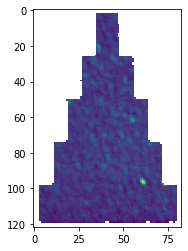

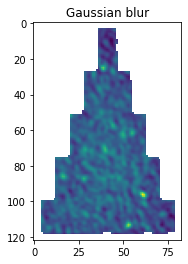

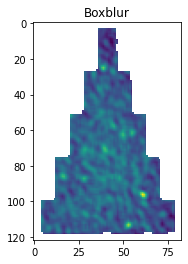

<Figure size 432x288 with 0 Axes>

In [5]:

windowSize = 7
# This could also be a gaussian
kernel = np.array([[1, 1, 1],
                   [1, 1, 1],
                   [1, 1, 1]])/9
_, object = next(objectinfo.sort_values(by=['VED']).iterrows())

sharpened[:, object.ystart:object.yend, object.xstart:object.xend]
img = filtered[93, object.ystart:object.yend, object.xstart:object.xend]
np.shape(img)
plt.imshow(img)
plt.figure()

# Gaussian below
veryBlurredLayers = np.array([cv2.GaussianBlur(image, (3,3), 0) for image in filtered])
# veryBlurredLayers = np.array([cv2.filter2D(src=image, ddepth=-1, kernel=kernel) for image in filtered])
(endLayer, _, _) = veryBlurredLayers.shape
print(endLayer)
neighbourhoodValues = np.array([np.sum(veryBlurredLayers[layerIndex-windowSize:layerIndex], axis=0)/windowSize
                               for layerIndex in range(windowSize, endLayer)])
plt.imshow(neighbourhoodValues[93, object.ystart:object.yend, object.xstart:object.xend])
plt.title("Gaussian blur")
plt.figure()

veryBlurredLayers = np.array([cv2.filter2D(src=image, ddepth=-1, kernel=kernel) for image in filtered])
(endLayer, _, _) = veryBlurredLayers.shape
print(endLayer)
neighbourhoodValues = np.array([np.sum(veryBlurredLayers[layerIndex-windowSize:layerIndex], axis=0)/windowSize
                               for layerIndex in range(windowSize, endLayer)])
plt.imshow(neighbourhoodValues[93, object.ystart:object.yend, object.xstart:object.xend])
plt.title("Boxblur")
plt.figure()

del veryBlurredLayers

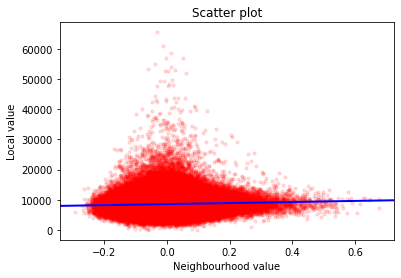

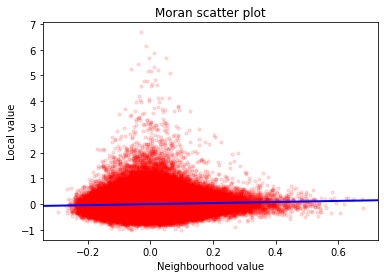

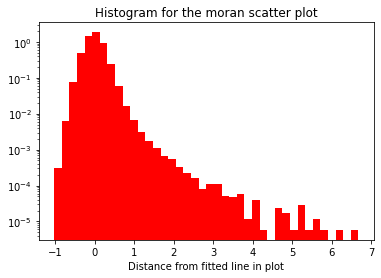

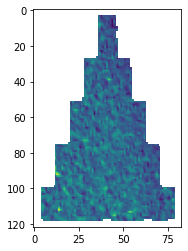

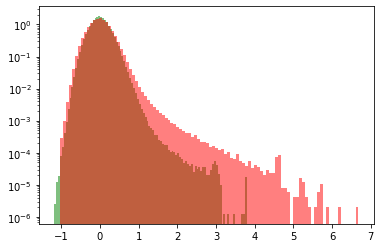

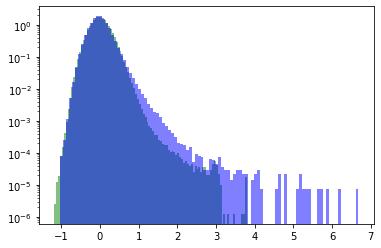

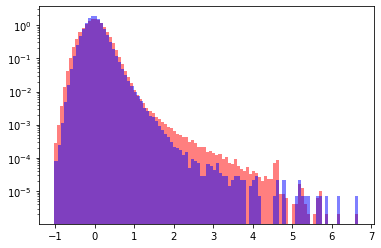

In [12]:
poorx = []
goodx = []
hotx = []
specialx = []

def flatten(xss):
    return [x for xs in xss for x in xs]
# ncopy[ncopy < 5000] = 0
# image_sharp[ncopy < 5000] = 0

for index, object in objectinfo.sort_values(by=['VED']).iterrows():
    #     plt.title("Object " + str(object.Object) + " segment " + str(object.Segment))
    # xs = integrals[windowSize-1:endLayer-1, object.ystart:object.yend,object.xstart:object.xend]
    xs = filtered[windowSize:, object.ystart:object.yend, object.xstart:object.xend]
    ys = neighbourhoodValues[:, object.ystart:object.yend, object.xstart:object.xend]
    filter = np.logical_and(np.isfinite(xs), np.isfinite(ys))
    line = np.polyfit(ys[filter].flatten(), xs[filter].flatten(), 1)
    p = np.poly1d(line)
    if object.Object == 'H26':
        specialx.append((xs-p(ys)).flatten())
    elif object.Porosity > 0.2:
        if object.Porosity > 10:
            rawxs = raw[windowSize:, object.ystart:object.yend, object.xstart:object.xend]
            rawys = rawneighbourhoodValues[:, object.ystart:object.yend, object.xstart:object.xend]
            rawfilter = np.logical_and(np.isfinite(rawxs), np.isfinite(rawys))
            rawline = np.polyfit(rawys[rawfilter].flatten(), rawxs[rawfilter].flatten(), 1)
            rawp = np.poly1d(rawline)
            plt.scatter(rawys[filter].flatten(), rawxs[filter].flatten(), color='r', s=10, alpha=0.125)
            plt.axline((-0.1, rawp(-0.1)), (0, rawp(0)), linewidth=2, color='b')
            plt.title("Scatter plot")
            plt.xlabel("Neighbourhood value")
            plt.ylabel("Local value")
            plt.figure()
            plt.scatter(ys[filter].flatten(), xs[filter].flatten(), color='r', s=10, alpha=0.125)
            plt.axline((-0.1, p(-0.1)), (0, p(0)), linewidth=2, color='b')
            plt.title("Moran scatter plot")
            plt.xlabel("Neighbourhood value")
            plt.ylabel("Local value")
            plt.figure()
            plt.hist((xs-p(ys)).flatten(), density=True, bins=40, color='r',)
            plt.title("Histogram for the moran scatter plot")
            plt.xlabel("Distance from fitted line in plot")
            plt.yscale('log')
            plt.figure()
            poorx.append((xs-p(ys)).flatten())
            specialx.append((xs-p(ys)).flatten())
            plt.imshow((xs-p(ys))[93, :, :])
            plt.figure()
        elif object.VED < 35:
            poorx.append((xs-p(ys)).flatten())
        else:
            hotx.append((xs-p(ys)).flatten())
    else:
        goodx.append((xs-p(ys)).flatten())
plt.hist(flatten(goodx), density=True, bins=100, color='g', alpha=0.5)
plt.hist(flatten(poorx), density=True, bins=100, color='r', alpha=0.5)
# plt.hist(flatten(hotx), bins=10, color='b', alpha=0.5)
plt.yscale('log')
plt.figure()

plt.hist(flatten(goodx), density=True, bins=100, color='g', alpha=0.5)
plt.hist(flatten(specialx), density=True, bins=100, color='b', alpha=0.5)
plt.yscale('log')
plt.figure()

plt.hist(flatten(poorx), density=True, bins=100, color='r', alpha=0.5)
plt.hist(flatten(specialx), density=True, bins=100, color='b', alpha=0.5)
plt.yscale('log')
